In [1]:
# RBC Model with endogenous labor
# VFI Iteration
# Prescott Kydland (1986)

In [ ]:
using Optim, Calculus, LinearAlgebra, NLsolve, Plots, StatsBase,  Roots
using Printf
Base.show(io::IO, f::Float64) = @printf(io, "%1.3f ", f)

function calibrate(wl_y_avg, i_k_avg, r_avg, c_y, le_l)
    # Use long run averages to pin down structural parameters that will explain short run dynamics
    α = 1 - wl_y_avg # Prodn Fn: wl/y = 1-α 
    δ = i_k_avg # Investment: i=k'-(1-δ)k 
    β = (1 + r_avg - δ)^(-1) # Euler on c: 1/c = βE(1/c' * (1+r'-δ)
    ϕ = (1-α) * le_l / c_y # Euler on l: 1/c = ϕ/((1-l)*MPL)
    return α, δ, β, ϕ
end

α, δ, β, ϕ = calibrate(0.667, 0.0233, 0.033, 0.767, 2)
println(α, δ, β, ϕ)

# Functions
F(z,k,l) = z*k^(α)*l^(1-α)
F1(z,k,l) = z*α*k^(α-1)*l^(1-α)
F2(z,k,l) = z*(1-α)*k^(α-1)*l^(-α)
C(z,k,l,kp) = F(z,k,l) + (1-δ)*k - kp
FOCL(l)= 1/C(z,k,l,kp) - ϕ/(1-l)/F2(z,k,l)

function steadyState(β, δ, α, ϕ)
    k_l = ((1/α)*((1/β)+δ-1))^(1/(α-1)) # from Euler on c
    y_l = k_l^α # Prodn Fn
    r_ss = α*(k_l)^(α-1)+(1-δ) 
    c_l = k_l^α - δ*k_l # from Budget
    l_ss = (1+ϕ*c_l/((1-α)*(k_l)^α))^(-1) # from Euler on l
    k_ss = l_ss * k_l
    y_ss = k_ss^α * l_ss^(1-α)
    c_ss = l_ss * c_l
    i_ss = δ*k_ss
    return r_ss, y_ss, c_ss, i_ss, l_ss, k_ss, k_l, y_l, c_l
end

r_ss, y_ss, c_ss, i_ss, l_ss, k_ss, k_l, y_l, c_l = steadyState(β, δ, α, ϕ)
println(l_ss, k_ss)

# Arrays
n_K = 100
n_L = 100
n_Z = 2
grid_K = Array(range(9,12,n_K))
grid_Z = Array([0.985, 1.015])
grid_L = Array(range(0.2, 0.6, n_L))
P = Array([0.95 0.05; 0.05 0.95])
grid_V = zeros(n_K,n_Z)
grid_kp = zeros(n_K,n_Z)
grid_l = zeros(n_K,n_Z)
grid_c = zeros(n_K,n_Z); 

# Simulate the Shock Process
function simulateAR1(N)
    path_z = zeros(N)
    path_z[1] = grid_Z[1]
    FN(a, b) = argmin(abs.(a .- b))
    for t in range(1,N-1,N-1)
        i = FN(grid_Z, path_z[Int(t)])
        path_z[Int(t)+1] = sample(grid_Z, ProbabilityWeights(P[Int(i), :]))
    end
    return path_z
end
path_z = simulateAR1(5000)
plot(path_z)

In [2]:
for i in range(1,50,50)
    for (k_i,k) in enumerate(grid_K)
        for (z_i,z) in enumerate(grid_Z)
            Vmax = -100
            V = -100
            V_best = -100
            c_best = c_ss
            l_best = l_ss
            kp_best = k_ss
            for (kp_i, kp) in enumerate(grid_K)
                for (l_i,l) in enumerate(grid_L)
                    c = C(z,k,l,kp)
                    if (c>0) & (kp>=0) & (kp<=F(z,k,l)+(1-δ)*k) & (l>0) & (l<1)
                        V = log(c) + ϕ*log(1-l) + β*dot(P[z_i,:], grid_V[kp_i, :])
                        if V>=Vmax
                            kp_best = kp
                            l_best = l
                            V_best = V
                            c_best = c
                       end
                    end
                end
            end
            grid_V[k_i,z_i] = V_best
            grid_l[k_i,z_i] = l_best
            grid_c[k_i,z_i] = c_best
            grid_kp[k_i,z_i] = kp_best
            println(k, z, kp_best, l_best, V_best)
        end
    end
end

9.000 0.985 10.242 0.600 -7.092 
9.000 1.015 10.273 0.600 -5.603 
9.030 0.985 10.273 0.600 -6.889 
9.030 1.015 10.303 0.600 -5.551 
9.061 0.985 10.303 0.600 -6.720 
9.061 1.015 10.333 0.600 -5.501 
9.091 0.985 10.333 0.600 -6.576 
9.091 1.015 10.364 0.600 -5.454 
9.121 0.985 10.364 0.600 -6.451 
9.121 1.015 10.394 0.600 -5.410 
9.152 0.985 10.394 0.600 -6.340 
9.152 1.015 10.424 0.600 -5.367 
9.182 0.985 10.424 0.600 -6.241 
9.182 1.015 10.455 0.600 -5.326 
9.212 0.985 10.455 0.600 -6.151 
9.212 1.015 10.485 0.600 -5.287 
9.242 0.985 10.485 0.600 -6.069 
9.242 1.015 10.515 0.600 -5.250 
9.273 0.985 10.515 0.600 -5.993 
9.273 1.015 10.545 0.600 -5.214 
9.303 0.985 10.545 0.600 -5.923 
9.303 1.015 10.576 0.600 -5.179 
9.333 0.985 10.576 0.600 -5.858 
9.333 1.015 10.606 0.600 -5.146 
9.364 0.985 10.606 0.600 -5.796 
9.364 1.015 10.636 0.600 -5.114 
9.394 0.985 10.636 0.600 -5.739 
9.394 1.015 10.697 0.600 -10.020 
9.424 0.985 10.667 0.600 -5.685 
9.424 1.015 10.727 0.600 -8.365 
9.455 0.9

10.576 0.985 11.848 0.600 -7.064 
10.576 1.015 11.909 0.600 -8.545 
10.606 0.985 11.879 0.600 -6.996 
10.606 1.015 11.939 0.600 -8.322 
10.636 0.985 11.909 0.600 -6.930 
10.636 1.015 11.970 0.600 -8.133 
10.667 0.985 11.939 0.600 -6.867 
10.667 1.015 12.000 0.600 -8.030 
10.697 0.985 11.970 0.600 -6.805 
10.697 1.015 12.000 0.600 -6.215 
10.727 0.985 12.000 0.600 -6.749 
10.727 1.015 12.000 0.600 -5.607 
10.758 0.985 12.000 0.600 -5.848 
10.758 1.015 12.000 0.600 -5.231 
10.788 0.985 12.000 0.600 -5.381 
10.788 1.015 12.000 0.600 -4.959 
10.818 0.985 12.000 0.600 -5.065 
10.818 1.015 12.000 0.600 -4.745 
10.848 0.985 12.000 0.600 -4.825 
10.848 1.015 12.000 0.600 -4.569 
10.879 0.985 12.000 0.600 -4.631 
10.879 1.015 12.000 0.600 -4.419 
10.909 0.985 12.000 0.600 -4.469 
10.909 1.015 12.000 0.600 -4.289 
10.939 0.985 12.000 0.600 -4.330 
10.939 1.015 12.000 0.600 -4.174 
10.970 0.985 12.000 0.600 -4.207 
10.970 1.015 12.000 0.600 -4.071 
11.000 0.985 12.000 0.600 -4.098 
11.000 1.015 1

9.061 1.015 10.333 0.600 -13.556 
9.091 0.985 10.333 0.600 -15.471 
9.091 1.015 10.364 0.600 -13.447 
9.121 0.985 10.364 0.600 -15.249 
9.121 1.015 10.394 0.600 -13.343 
9.152 0.985 10.394 0.600 -15.046 
9.152 1.015 10.424 0.600 -13.243 
9.182 0.985 10.424 0.600 -14.860 
9.182 1.015 10.455 0.600 -17.200 
9.212 0.985 10.455 0.600 -14.901 
9.212 1.015 10.485 0.600 -16.091 
9.242 0.985 10.485 0.600 -14.686 
9.242 1.015 10.515 0.600 -15.544 
9.273 0.985 10.515 0.600 -14.511 
9.273 1.015 10.545 0.600 -15.165 
9.303 0.985 10.545 0.600 -14.353 
9.303 1.015 10.576 0.600 -14.869 
9.333 0.985 10.576 0.600 -14.207 
9.333 1.015 10.606 0.600 -14.623 
9.364 0.985 10.606 0.600 -14.071 
9.364 1.015 10.636 0.600 -14.410 
9.394 0.985 10.636 0.600 -13.942 
9.394 1.015 10.697 0.600 -17.504 
9.424 0.985 10.667 0.600 -13.823 
9.424 1.015 10.727 0.600 -15.274 
9.455 0.985 10.697 0.600 -13.625 
9.455 1.015 10.758 0.600 -14.285 
9.485 0.985 10.727 0.600 -13.493 
9.485 1.015 10.788 0.600 -13.638 
9.515 0.985 10

10.576 1.015 11.909 0.600 -12.445 
10.606 0.985 11.879 0.600 -10.836 
10.606 1.015 11.939 0.600 -12.222 
10.636 0.985 11.909 0.600 -10.770 
10.636 1.015 11.970 0.600 -12.033 
10.667 0.985 11.939 0.600 -10.706 
10.667 1.015 12.000 0.600 -11.929 
10.697 0.985 11.970 0.600 -10.645 
10.697 1.015 12.000 0.600 -10.113 
10.727 0.985 12.000 0.600 -10.589 
10.727 1.015 12.000 0.600 -9.505 
10.758 0.985 12.000 0.600 -9.687 
10.758 1.015 12.000 0.600 -9.130 
10.788 0.985 12.000 0.600 -9.221 
10.788 1.015 12.000 0.600 -8.857 
10.818 0.985 12.000 0.600 -8.904 
10.818 1.015 12.000 0.600 -8.644 
10.848 0.985 12.000 0.600 -8.664 
10.848 1.015 12.000 0.600 -8.468 
10.879 0.985 12.000 0.600 -8.471 
10.879 1.015 12.000 0.600 -8.318 
10.909 0.985 12.000 0.600 -8.309 
10.909 1.015 12.000 0.600 -8.188 
10.939 0.985 12.000 0.600 -8.169 
10.939 1.015 12.000 0.600 -8.073 
10.970 0.985 12.000 0.600 -8.047 
10.970 1.015 12.000 0.600 -7.970 
11.000 0.985 12.000 0.600 -7.938 
11.000 1.015 12.000 0.600 -7.876 
11.0

9.061 0.985 10.303 0.600 -19.489 
9.061 1.015 10.333 0.600 -17.374 
9.091 0.985 10.333 0.600 -19.242 
9.091 1.015 10.364 0.600 -17.266 
9.121 0.985 10.364 0.600 -19.020 
9.121 1.015 10.394 0.600 -17.162 
9.152 0.985 10.394 0.600 -18.818 
9.152 1.015 10.424 0.600 -17.062 
9.182 0.985 10.424 0.600 -18.632 
9.182 1.015 10.455 0.600 -21.019 
9.212 0.985 10.455 0.600 -18.673 
9.212 1.015 10.485 0.600 -19.909 
9.242 0.985 10.485 0.600 -18.458 
9.242 1.015 10.515 0.600 -19.363 
9.273 0.985 10.515 0.600 -18.283 
9.273 1.015 10.545 0.600 -18.984 
9.303 0.985 10.545 0.600 -18.125 
9.303 1.015 10.576 0.600 -18.688 
9.333 0.985 10.576 0.600 -17.979 
9.333 1.015 10.606 0.600 -18.441 
9.364 0.985 10.606 0.600 -17.843 
9.364 1.015 10.636 0.600 -18.228 
9.394 0.985 10.636 0.600 -17.714 
9.394 1.015 10.697 0.600 -21.321 
9.424 0.985 10.667 0.600 -17.595 
9.424 1.015 10.727 0.600 -19.091 
9.455 0.985 10.697 0.600 -17.396 
9.455 1.015 10.758 0.600 -18.102 
9.485 0.985 10.727 0.600 -17.265 
9.485 1.015 10

10.545 0.985 11.818 0.600 -14.713 
10.545 1.015 11.879 0.600 -16.496 
10.576 0.985 11.848 0.600 -14.642 
10.576 1.015 11.909 0.600 -16.222 
10.606 0.985 11.879 0.600 -14.573 
10.606 1.015 11.939 0.600 -15.999 
10.636 0.985 11.909 0.600 -14.508 
10.636 1.015 11.970 0.600 -15.810 
10.667 0.985 11.939 0.600 -14.444 
10.667 1.015 12.000 0.600 -15.704 
10.697 0.985 11.970 0.600 -14.383 
10.697 1.015 12.000 0.600 -13.888 
10.727 0.985 12.000 0.600 -14.326 
10.727 1.015 12.000 0.600 -13.280 
10.758 0.985 12.000 0.600 -13.425 
10.758 1.015 12.000 0.600 -12.905 
10.788 0.985 12.000 0.600 -12.959 
10.788 1.015 12.000 0.600 -12.633 
10.818 0.985 12.000 0.600 -12.642 
10.818 1.015 12.000 0.600 -12.419 
10.848 0.985 12.000 0.600 -12.402 
10.848 1.015 12.000 0.600 -12.243 
10.879 0.985 12.000 0.600 -12.208 
10.879 1.015 12.000 0.600 -12.093 
10.909 0.985 12.000 0.600 -12.046 
10.909 1.015 12.000 0.600 -11.963 
10.939 0.985 12.000 0.600 -11.907 
10.939 1.015 12.000 0.600 -11.848 
10.970 0.985 12.000 

11.970 1.015 12.000 0.600 -11.534 
12.000 0.985 12.000 0.600 -11.417 
12.000 1.015 12.000 0.600 -11.572 
9.000 0.985 10.242 0.600 -23.757 
9.000 1.015 10.273 0.600 -21.305 
9.030 0.985 10.273 0.600 -23.436 
9.030 1.015 10.303 0.600 -21.187 
9.061 0.985 10.303 0.600 -23.158 
9.061 1.015 10.333 0.600 -21.074 
9.091 0.985 10.333 0.600 -22.912 
9.091 1.015 10.364 0.600 -20.965 
9.121 0.985 10.364 0.600 -22.690 
9.121 1.015 10.394 0.600 -20.861 
9.152 0.985 10.394 0.600 -22.488 
9.152 1.015 10.424 0.600 -20.761 
9.182 0.985 10.424 0.600 -22.301 
9.182 1.015 10.455 0.600 -24.718 
9.212 0.985 10.455 0.600 -22.342 
9.212 1.015 10.485 0.600 -23.608 
9.242 0.985 10.485 0.600 -22.128 
9.242 1.015 10.515 0.600 -23.062 
9.273 0.985 10.515 0.600 -21.952 
9.273 1.015 10.545 0.600 -22.683 
9.303 0.985 10.545 0.600 -21.795 
9.303 1.015 10.576 0.600 -22.387 
9.333 0.985 10.576 0.600 -21.649 
9.333 1.015 10.606 0.600 -22.141 
9.364 0.985 10.606 0.600 -21.512 
9.364 1.015 10.636 0.600 -21.928 
9.394 0.985

10.394 1.015 11.697 0.600 -17.989 
10.424 0.985 11.697 0.600 -18.666 
10.424 1.015 11.727 0.600 -17.933 
10.455 0.985 11.727 0.600 -18.581 
10.455 1.015 11.788 0.600 -22.187 
10.485 0.985 11.758 0.600 -18.500 
10.485 1.015 11.818 0.600 -21.053 
10.515 0.985 11.788 0.600 -18.422 
10.515 1.015 11.848 0.600 -20.516 
10.545 0.985 11.818 0.600 -18.348 
10.545 1.015 11.879 0.600 -20.155 
10.576 0.985 11.848 0.600 -18.277 
10.576 1.015 11.909 0.600 -19.881 
10.606 0.985 11.879 0.600 -18.209 
10.606 1.015 11.939 0.600 -19.658 
10.636 0.985 11.909 0.600 -18.143 
10.636 1.015 11.970 0.600 -19.469 
10.667 0.985 11.939 0.600 -18.079 
10.667 1.015 12.000 0.600 -19.362 
10.697 0.985 11.970 0.600 -18.018 
10.697 1.015 12.000 0.600 -17.546 
10.727 0.985 12.000 0.600 -17.962 
10.727 1.015 12.000 0.600 -16.938 
10.758 0.985 12.000 0.600 -17.060 
10.758 1.015 12.000 0.600 -16.563 
10.788 0.985 12.000 0.600 -16.594 
10.788 1.015 12.000 0.600 -16.290 
10.818 0.985 12.000 0.600 -16.277 
10.818 1.015 12.000 

LoadError: SYSTEM: show(lasterr) caused an error

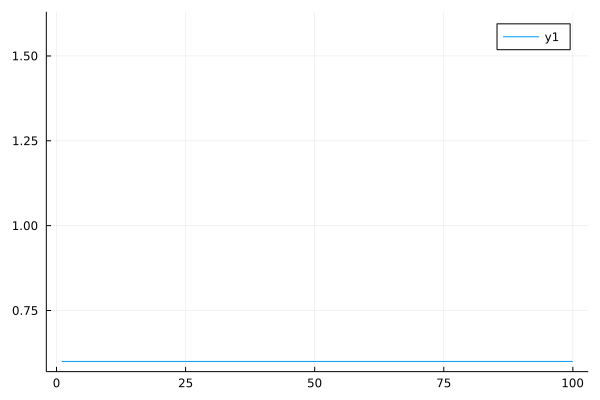

In [3]:
plot(grid_l[:,1])

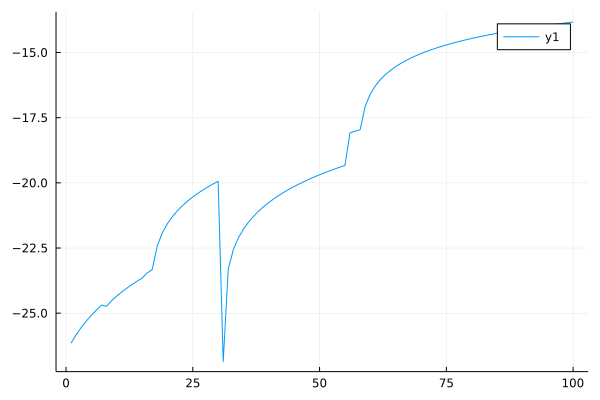

In [4]:
plot(grid_V[:,1])